In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from wrangle_zillow import prepare_zillow, get_zillow_data
import stats_util

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Clustering Explore Exercises

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

2. Answer those questions through a mix of statistical tests and visualizations.

In [3]:
train, validate, test = prepare_zillow(get_zillow_data())

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40255 entries, 66432 to 47121
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            40255 non-null  int64  
 1   parcelid                      40255 non-null  int64  
 2   bathroomcnt                   40255 non-null  float64
 3   bedroomcnt                    40255 non-null  float64
 4   calculatedbathnbr             40255 non-null  float64
 5   calculatedfinishedsquarefeet  40255 non-null  float64
 6   finishedsquarefeet12          40255 non-null  float64
 7   fips                          40255 non-null  float64
 8   fullbathcnt                   40255 non-null  float64
 9   latitude                      40255 non-null  float64
 10  longitude                     40255 non-null  float64
 11  propertycountylandusecode     40255 non-null  object 
 12  rawcensustractandblock        40255 non-null  float64
 1

## Is logerror significantly different for properties in LA County vs. Orange County vs. Ventura County?

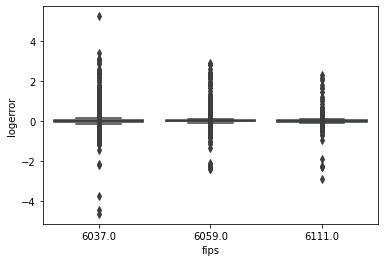

In [5]:
sns.boxplot(data = train, x = 'fips', y = 'logerror');

It's hard to tell if there is any significant difference in logerror between each county because of all the outliers.

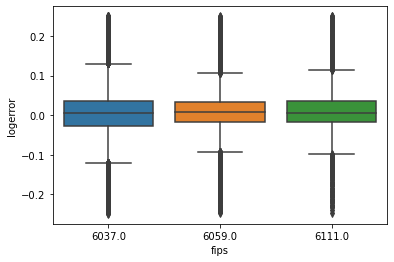

In [6]:
mask = (train.logerror < 0.25) & (train.logerror > -0.25)
sns.boxplot(data = train[mask], x = 'fips', y = 'logerror');

Here we can see it a little clearer. There doesn't seem to be any significant difference in logerror between each county.

In [7]:
la_county = train.fips == 6037.0
orange_county = train.fips == 6059.0
ventura_county = train.fips == 6111.0

stats_util.equal_var_test(train[la_county].logerror, train[orange_county].logerror, train[ventura_county].logerror)

False

The variances are not equal so we must use two sample t-tests.

In [8]:
stats_util.two_sample_ttest(train[la_county].logerror, train[~la_county].logerror)

Samples contain more than 30 observations: True
Samples have equal variances: False
Using parametric test...

Reject H0


In [9]:
stats_util.two_sample_ttest(train[~ventura_county].logerror, train[ventura_county].logerror)

Samples contain more than 30 observations: True
Samples have equal variances: False
Using parametric test...

Fail to Reject H0


In [10]:
stats_util.two_sample_ttest(train[~orange_county].logerror, train[orange_county].logerror)

Samples contain more than 30 observations: True
Samples have equal variances: False
Using parametric test...

Reject H0


We reject the null hypothesis that the logerror between LA County and Orange County are not significantly different, but fail to reject the null hypothesis for the same comparison between LA County and Ventura County, and Orange County and Ventura County.

## Does logerror correlate with square feet?

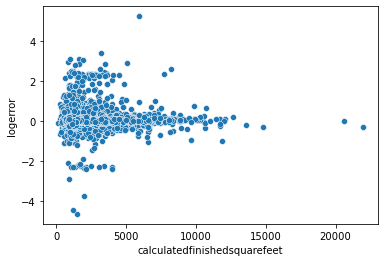

In [11]:
sns.scatterplot(data = train, x = 'calculatedfinishedsquarefeet', y = 'logerror');

In [12]:
train['logerror_abs'] = abs(train.logerror)

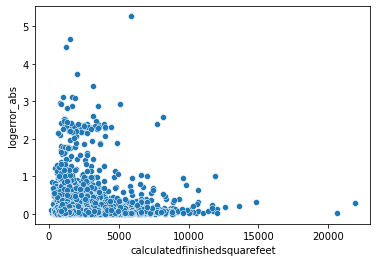

In [46]:
sns.scatterplot(data = train, x = 'calculatedfinishedsquarefeet', y = 'logerror_abs');

In [36]:
stats.pearsonr(train.logerror, train.calculatedfinishedsquarefeet)

(0.03607804742147816, 4.463583567079344e-13)

In [37]:
stats.pearsonr(train.logerror_abs, train.calculatedfinishedsquarefeet)

(0.049327368579563484, 4.0562898045069003e-23)

The correlation is close to zero. If another variable is added into the mix this might provide a better idea of how these two variables relate to each. It also could be valuable to do a means test between the subsets of smaller properties and larger properties.

## Is logerror significantly different for different property types?

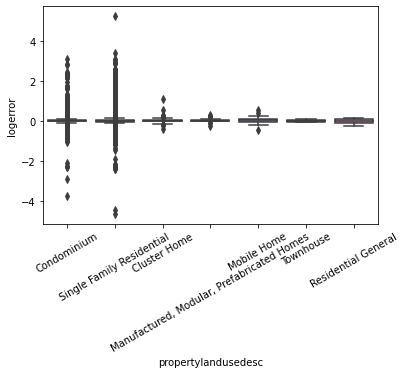

In [15]:
sns.boxplot(data = train, x = 'propertylandusedesc', y = 'logerror')
plt.xticks(rotation = 30);

Again hard to tell with all the outliers.

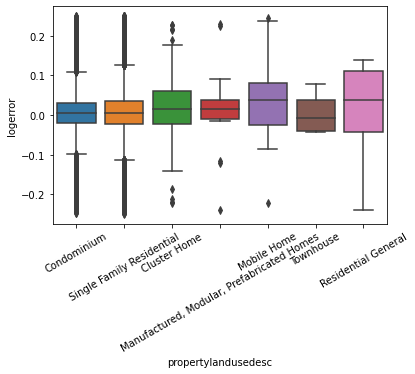

In [16]:
mask = (train.logerror < 0.25) & (train.logerror > -0.25)
sns.boxplot(data = train[mask], x = 'propertylandusedesc', y = 'logerror')
plt.xticks(rotation = 30);

In [17]:
(train.propertylandusedesc == 'Single Family Residential').value_counts()

True     29227
False    11028
Name: propertylandusedesc, dtype: int64

There does appear to be some differences here. Since single family residential makes up most of the data let's see if there is a difference between this type and the rest of the properties.

In [18]:
mask = train.propertylandusedesc == 'Single Family Residential'
stats_util.two_sample_ttest(train[mask].logerror, train[~mask].logerror)

Samples contain more than 30 observations: True
Samples have equal variances: False
Using parametric test...

Fail to Reject H0


We fail to reject the null hypothesis that there is no significant difference in logerror betwee single family residential properties and non single family residential properties.

## Is there a relationship between the year a property was built and the logerror?

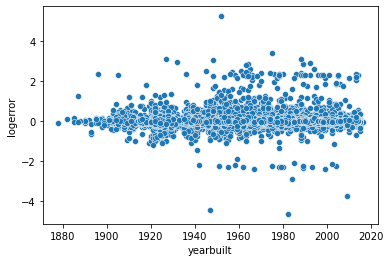

In [19]:
sns.scatterplot(data = train, x = 'yearbuilt', y = 'logerror');

What if we take the absolute value of logerror?

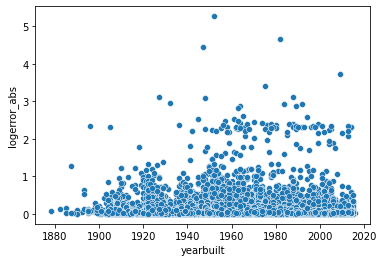

In [20]:
sns.scatterplot(data = train, x = 'yearbuilt', y = 'logerror_abs');

There may be some correlation here.

In [21]:
stats_util.correlation_test(train.yearbuilt, train.logerror_abs)

r = -0.0823
p = 0.0000

Reject H0


There is a very weak correlation here.

## Is there any relationship between bathroom/bedroom count and logerror?

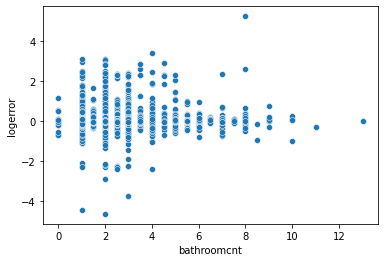

In [22]:
sns.scatterplot(data = train, x = 'bathroomcnt', y = 'logerror');

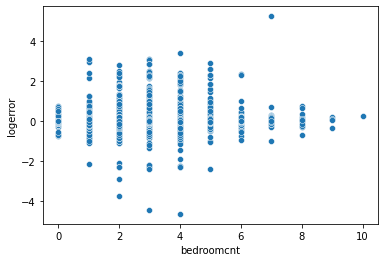

In [23]:
sns.scatterplot(data = train, x = 'bedroomcnt', y = 'logerror');

What if we use the absolute value of logerror?

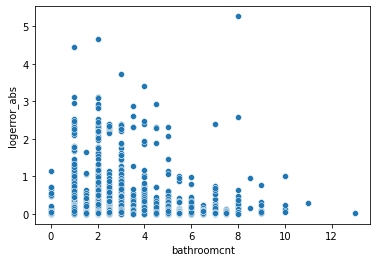

In [24]:
sns.scatterplot(data = train, x = 'bathroomcnt', y = 'logerror_abs');

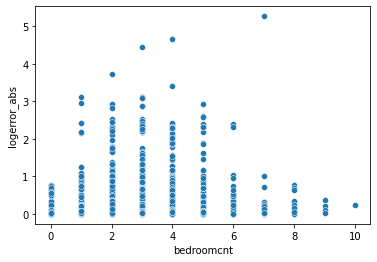

In [25]:
sns.scatterplot(data = train, x = 'bedroomcnt', y = 'logerror_abs');

There may be a relationship here.

In [26]:
stats_util.correlation_test(train.bathroomcnt, train.logerror_abs)

r = 0.0098
p = 0.0503

Fail to Reject H0


In [27]:
stats_util.correlation_test(train.bedroomcnt, train.logerror_abs)

r = 0.0049
p = 0.3252

Fail to Reject H0


It seems the correlations here are very weak.

## Bonus

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [28]:
mean_logerror = train.logerror.mean()
mean_logerror

0.01700081819894274

In [29]:
α = 0.05
zip_codes = []

for zip_code in train.regionidzip.unique():
    mask = train.regionidzip == zip_code
    t, p = stats.ttest_1samp(train[mask].logerror, mean_logerror)
    
    if p < α:
        zip_codes.append(zip_code)
        
print(zip_codes)

[96377.0, 97113.0, 96046.0, 97330.0, 96217.0, 96026.0, 96104.0, 97051.0, 96517.0, 96047.0, 96020.0, 96197.0, 96128.0, 97063.0, 95989.0, 96962.0, 96216.0, 96152.0, 96120.0, 96160.0, 96452.0, 95984.0, 96105.0, 96102.0, 96294.0, 96941.0, 96171.0, 96244.0, 96289.0, 96007.0, 96023.0, 96103.0, 96330.0, 96356.0, 96508.0, 96022.0, 97084.0, 95997.0, 96280.0, 96946.0, 96387.0, 96327.0, 96097.0, 96016.0, 96038.0, 96326.0, 96107.0, 96134.0, 96043.0, 96951.0, 96137.0, 96973.0]


In [30]:
pd.DataFrame({
    'zip_code' : zip_codes,
    'mean_log_error' : [
        train[train.regionidzip == zip_code].logerror.mean()
        for zip_code in zip_codes
    ]
}).sort_values(by = 'mean_log_error')

,zip_code,mean_log_error
21,95984.0,-0.067969
48,96043.0,-0.060920
38,96280.0,-0.049563
50,96137.0,-0.047517
10,96020.0,-0.045067
51,96973.0,-0.044994
29,96007.0,-0.044854
42,96097.0,-0.038763
35,96022.0,-0.032908
37,95997.0,-0.031957


In [31]:
# How many properties are in 96951?
train[train.regionidzip == 96951.0].size

308

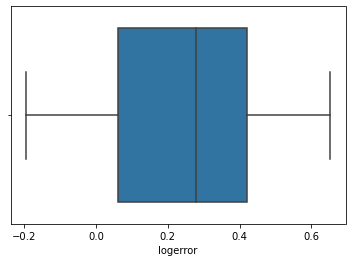

In [32]:
sns.boxplot(train[train.regionidzip == 96951.0].logerror);

**Additional Notes**

- Could also be valuable to look at how logerror relates to the property value.
- Maybe proximity to the coastline might relate to property value and logerror. (longitude)